# Random correlation example

## Generating correlation matrix

In [ ]:
n = 10
R = np.identity(n)
# R[0,1] = 0.9
# R[1,2] = 0.9
# R[0,2] = 0.0

r = np.random.uniform(-1,1,(n)*(n-1)//2)
r = np.sign(r) * np.abs(r)**2

R[np.triu_indices(n,1)] = r

In [ ]:
R = np.triu(R) + np.triu(R).T - np.identity(10)

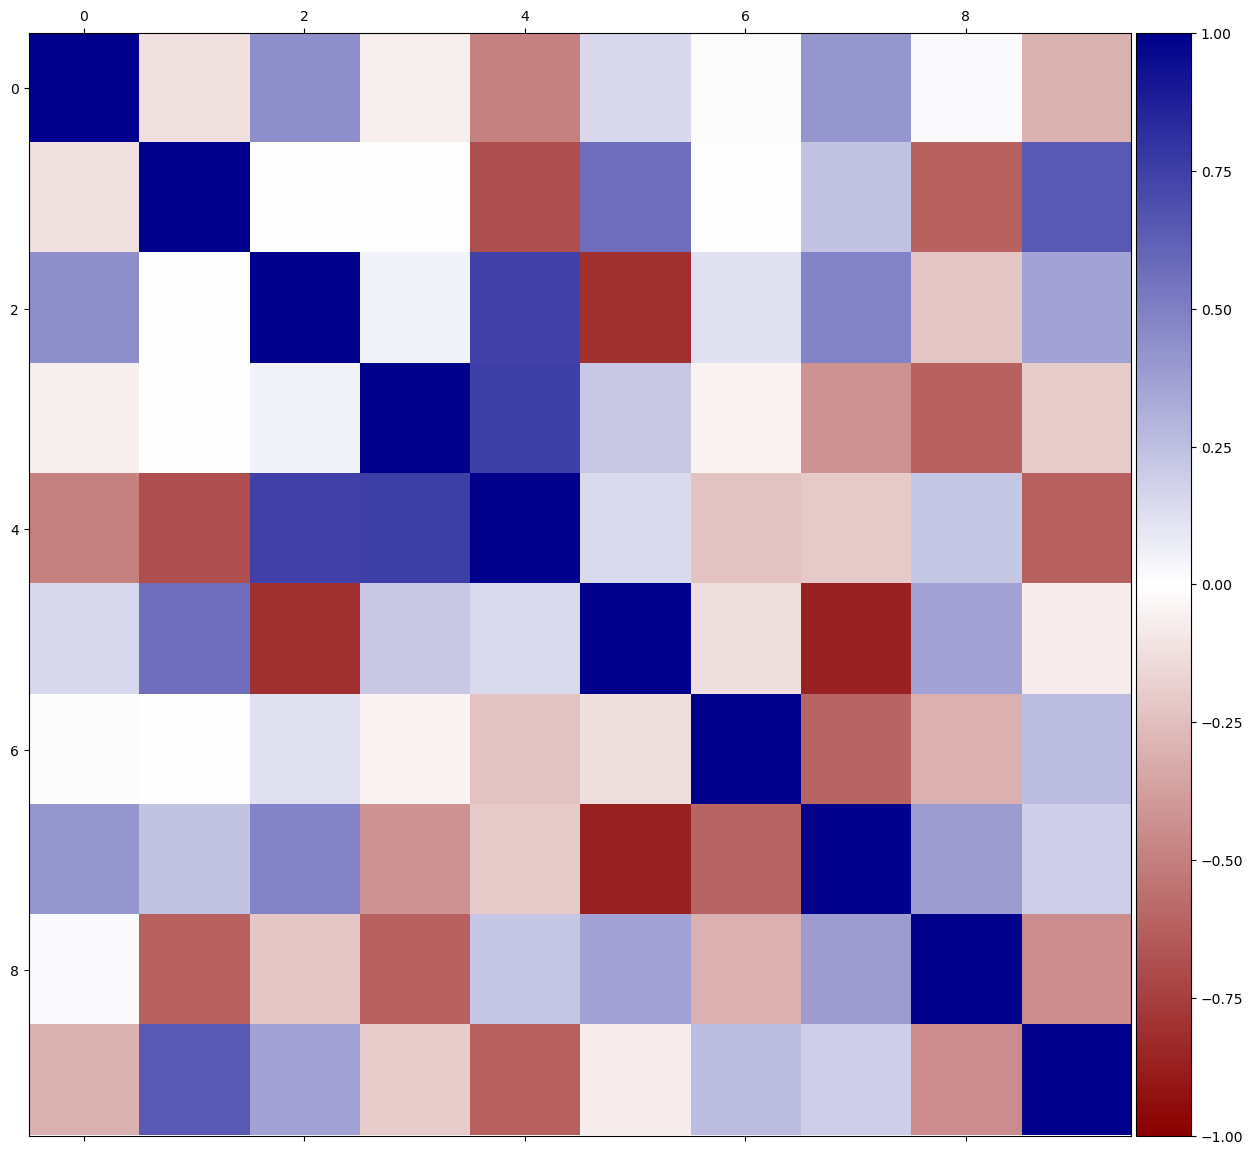

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(15,15))
r = ax.matshow(R, cmap = colormap_corr, vmin = -1, vmax = 1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(r, cax=cax)
# try:
#     ax.set_xticks([x for x in range(labels_select.__len__())], labels_select, rotation='vertical');
#     ax.set_yticks([x for x in range(labels_select.__len__())], labels_select);
# except:
#     None

In [ ]:
eg_res = np.linalg.eig(R)
ev = eg_res.eigenvalues

ev[ev < 0] = 0
ev[ev > 1] = 1


LOL = eg_res.eigenvectors.T @ np.diag(ev) @ eg_res.eigenvectors

std = np.diag(LOL)**0.5

LOL = LOL * std**(-1) * std[:,None]**(-1)


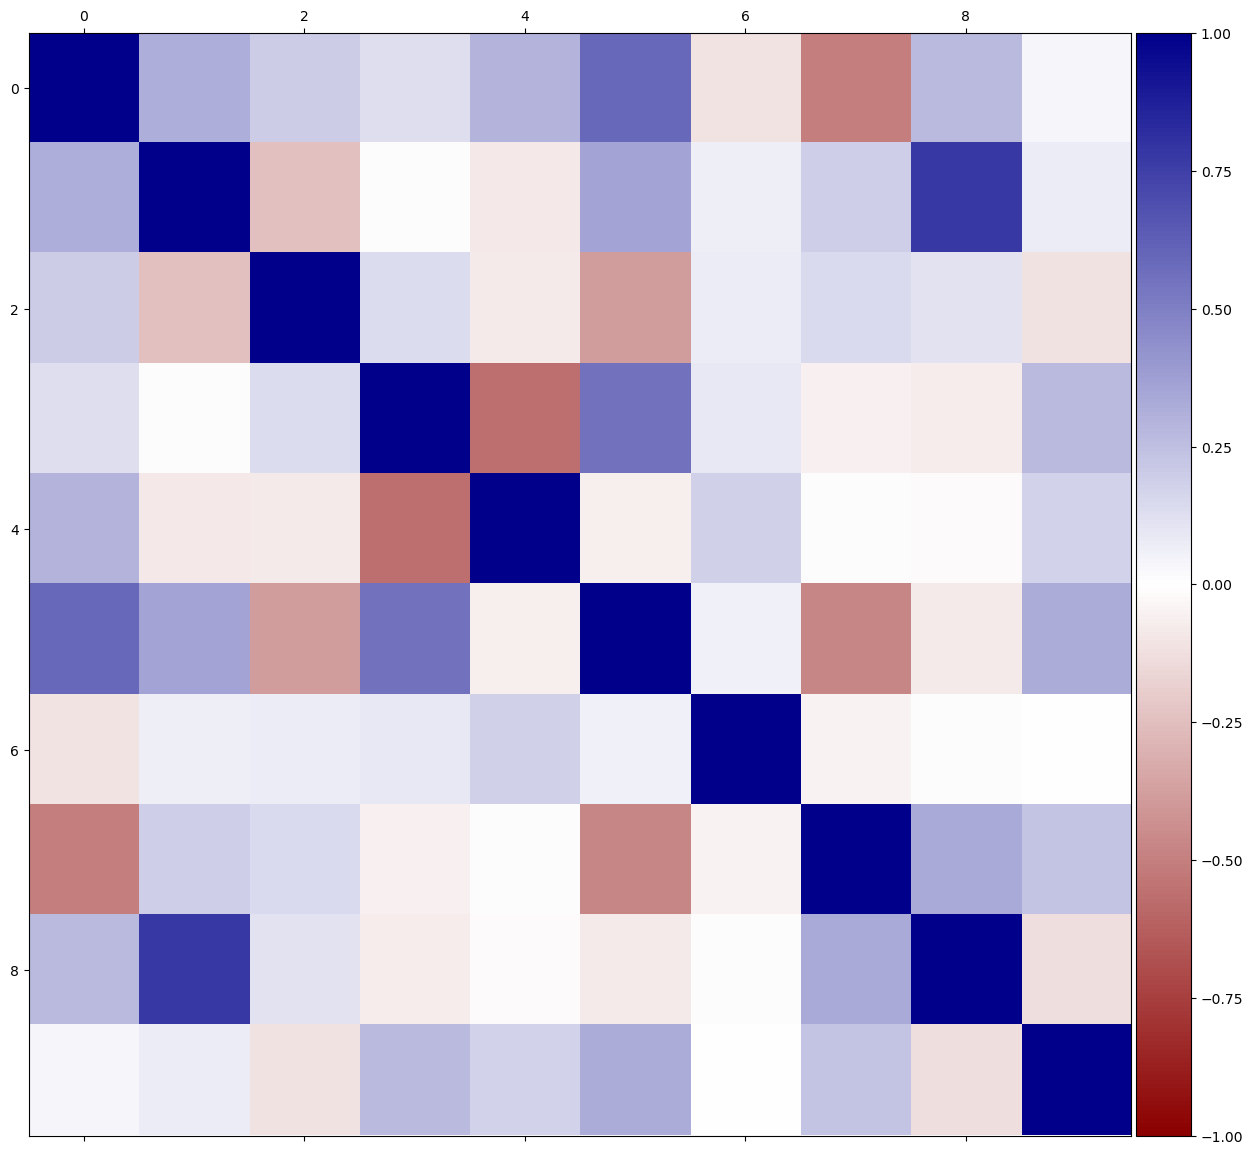

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(15,15))
r = ax.matshow(LOL, cmap = colormap_corr, vmin = -1, vmax = 1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(r, cax=cax)
# try:
#     ax.set_xticks([x for x in range(labels_select.__len__())], labels_select, rotation='vertical');
#     ax.set_yticks([x for x in range(labels_select.__len__())], labels_select);
# except:
#     None

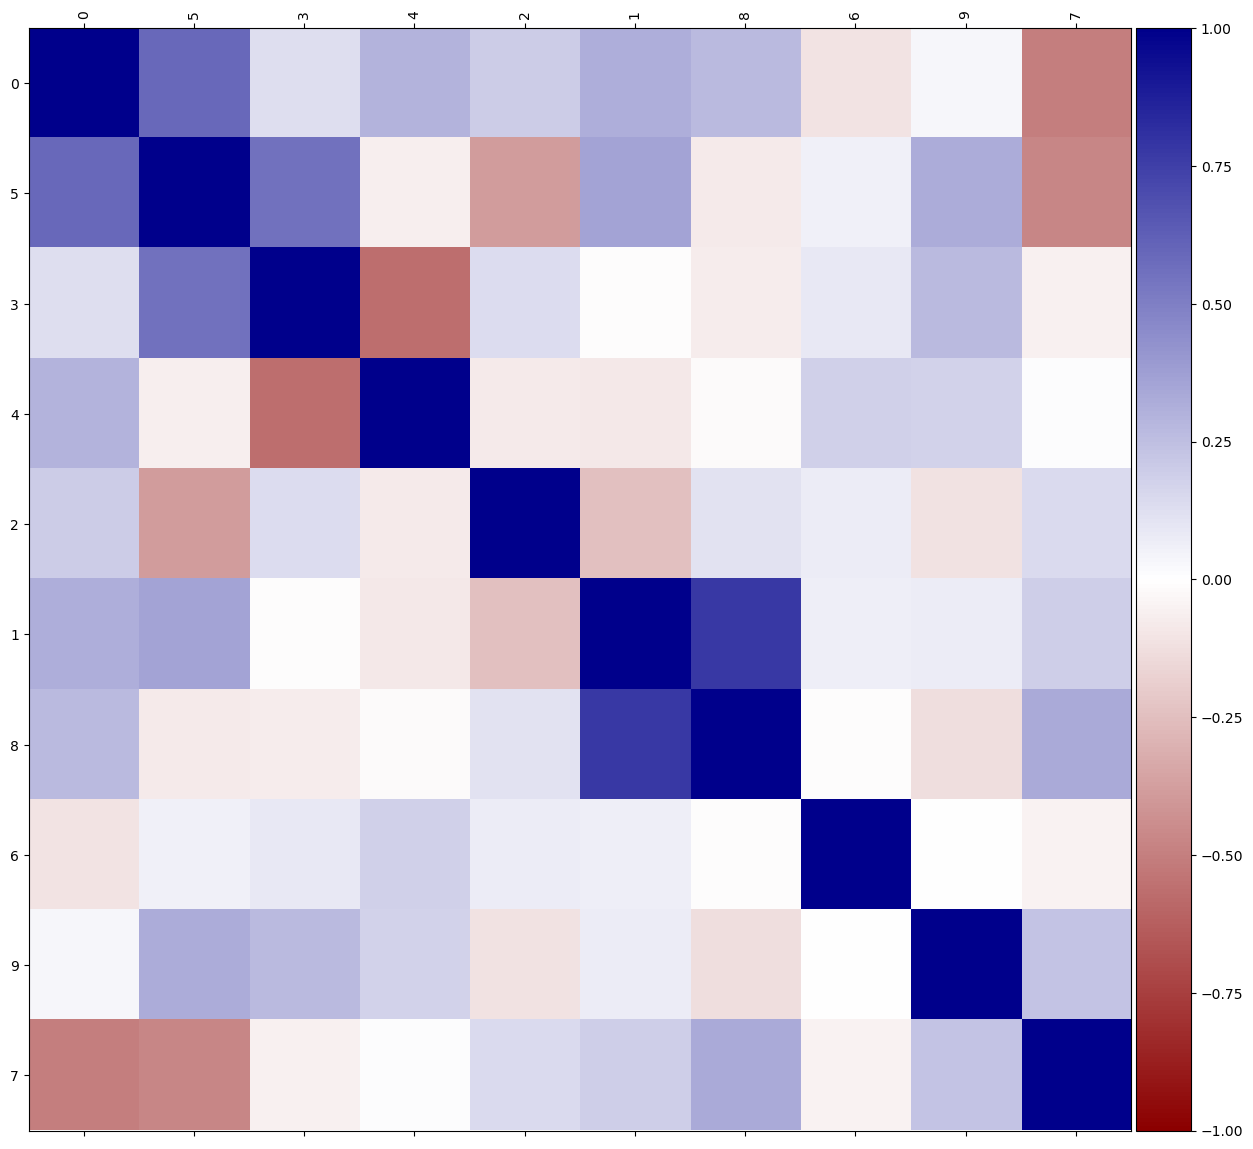

In [ ]:
order_idx = [0,5,3,4,2,1,8,6,9,7]

fig, ax = plt.subplots(1,1,figsize=(15,15))
r = ax.matshow(LOL[order_idx,:][:,order_idx], cmap = colormap_corr, vmin = -1, vmax = 1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(r, cax=cax)
try:
    ax.set_xticks([x for x in range(n)], order_idx, rotation='vertical');
    ax.set_yticks([x for x in range(n)], order_idx);
except:
    None

In [ ]:
cor = LOL[order_idx,:][:,order_idx].copy()

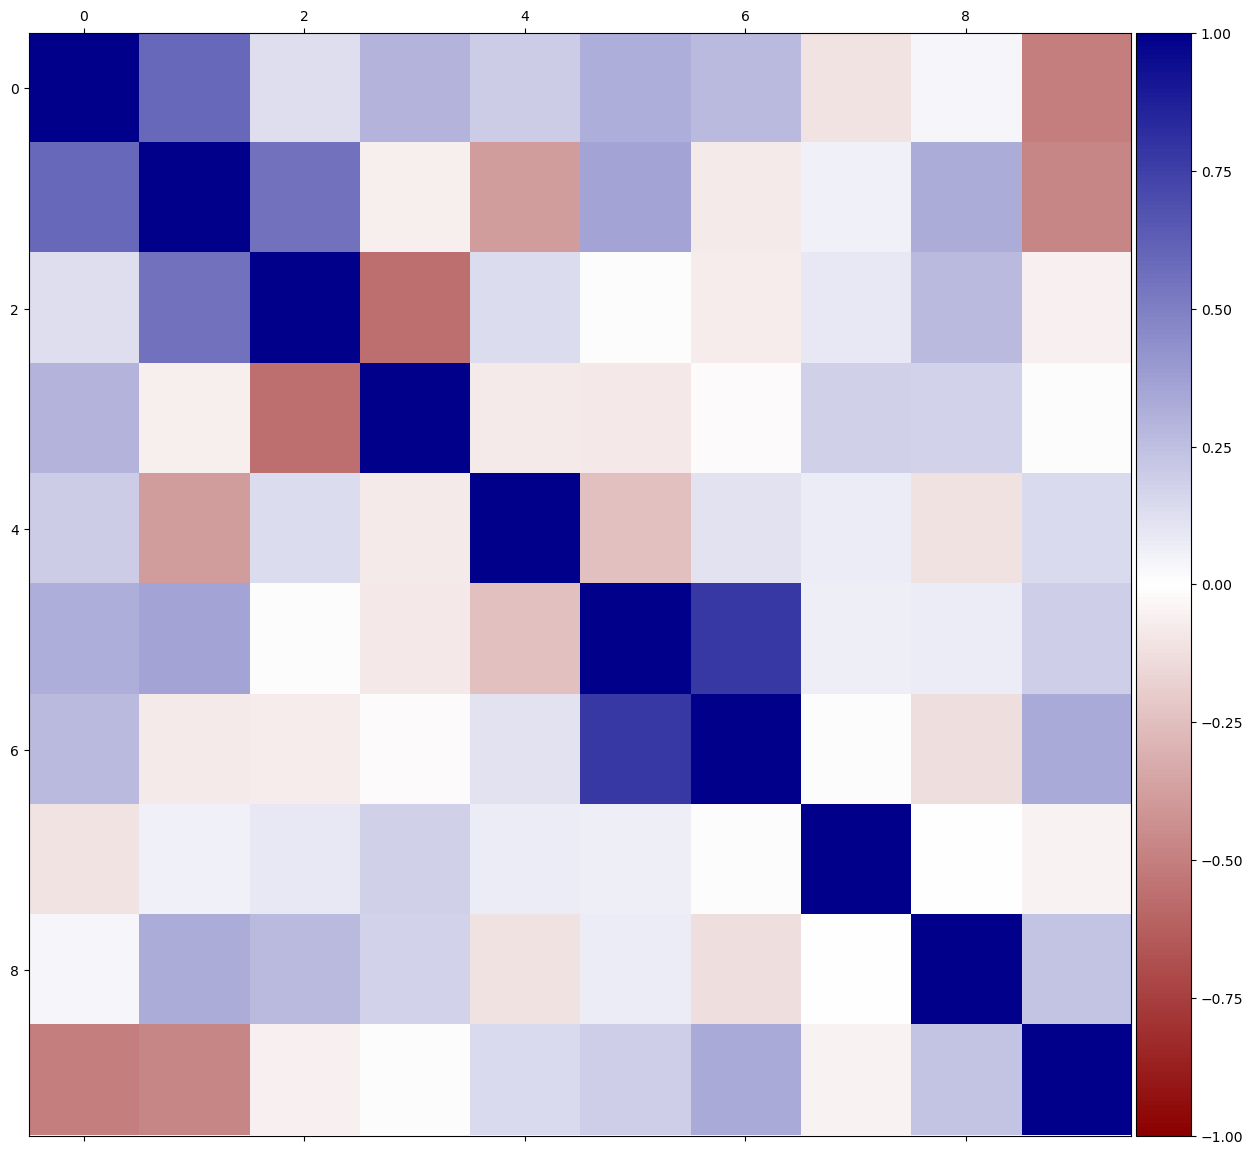

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(15,15))
r = ax.matshow(cor, cmap = colormap_corr, vmin = -1, vmax = 1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(r, cax=cax)
# try:
#     ax.set_xticks([x for x in range(n)], order_idx, rotation='vertical');
#     ax.set_yticks([x for x in range(n)], order_idx);
# except:
#     None

## Simulation

In [ ]:
N=10
n_sample = 10_000

mean = np.zeros(N)
# np.save("N10by10_cor.npy",cor)
cor = np.load("N10by10_cor.npy")

X = np.random.default_rng().multivariate_normal(mean = mean, cov = cor, size = n_sample).T

In [ ]:
X.shape

(10, 10000)

In [ ]:
# Prepare Kernels, transformed data to uniform (from kernel), Scott's optimal bandwiths
kernels_X = [gaussian_kde(X[i,:]) for i in tqdm(range(N))]

U = np.vstack( [np.array([kernels_X[i].integrate_box_1d(-np.inf, x_i) for x_i in X[i,:]]) for i in tqdm(range(N)) ])
kernels_U = [gaussian_kde(U[i,:]) for i in tqdm(range(N))]

h = np.array([(kernels_X[i].covariance**0.5)[0,0] for i in tqdm(range(N))])

100%|██████████| 10/10 [00:00<?, ?it/s]


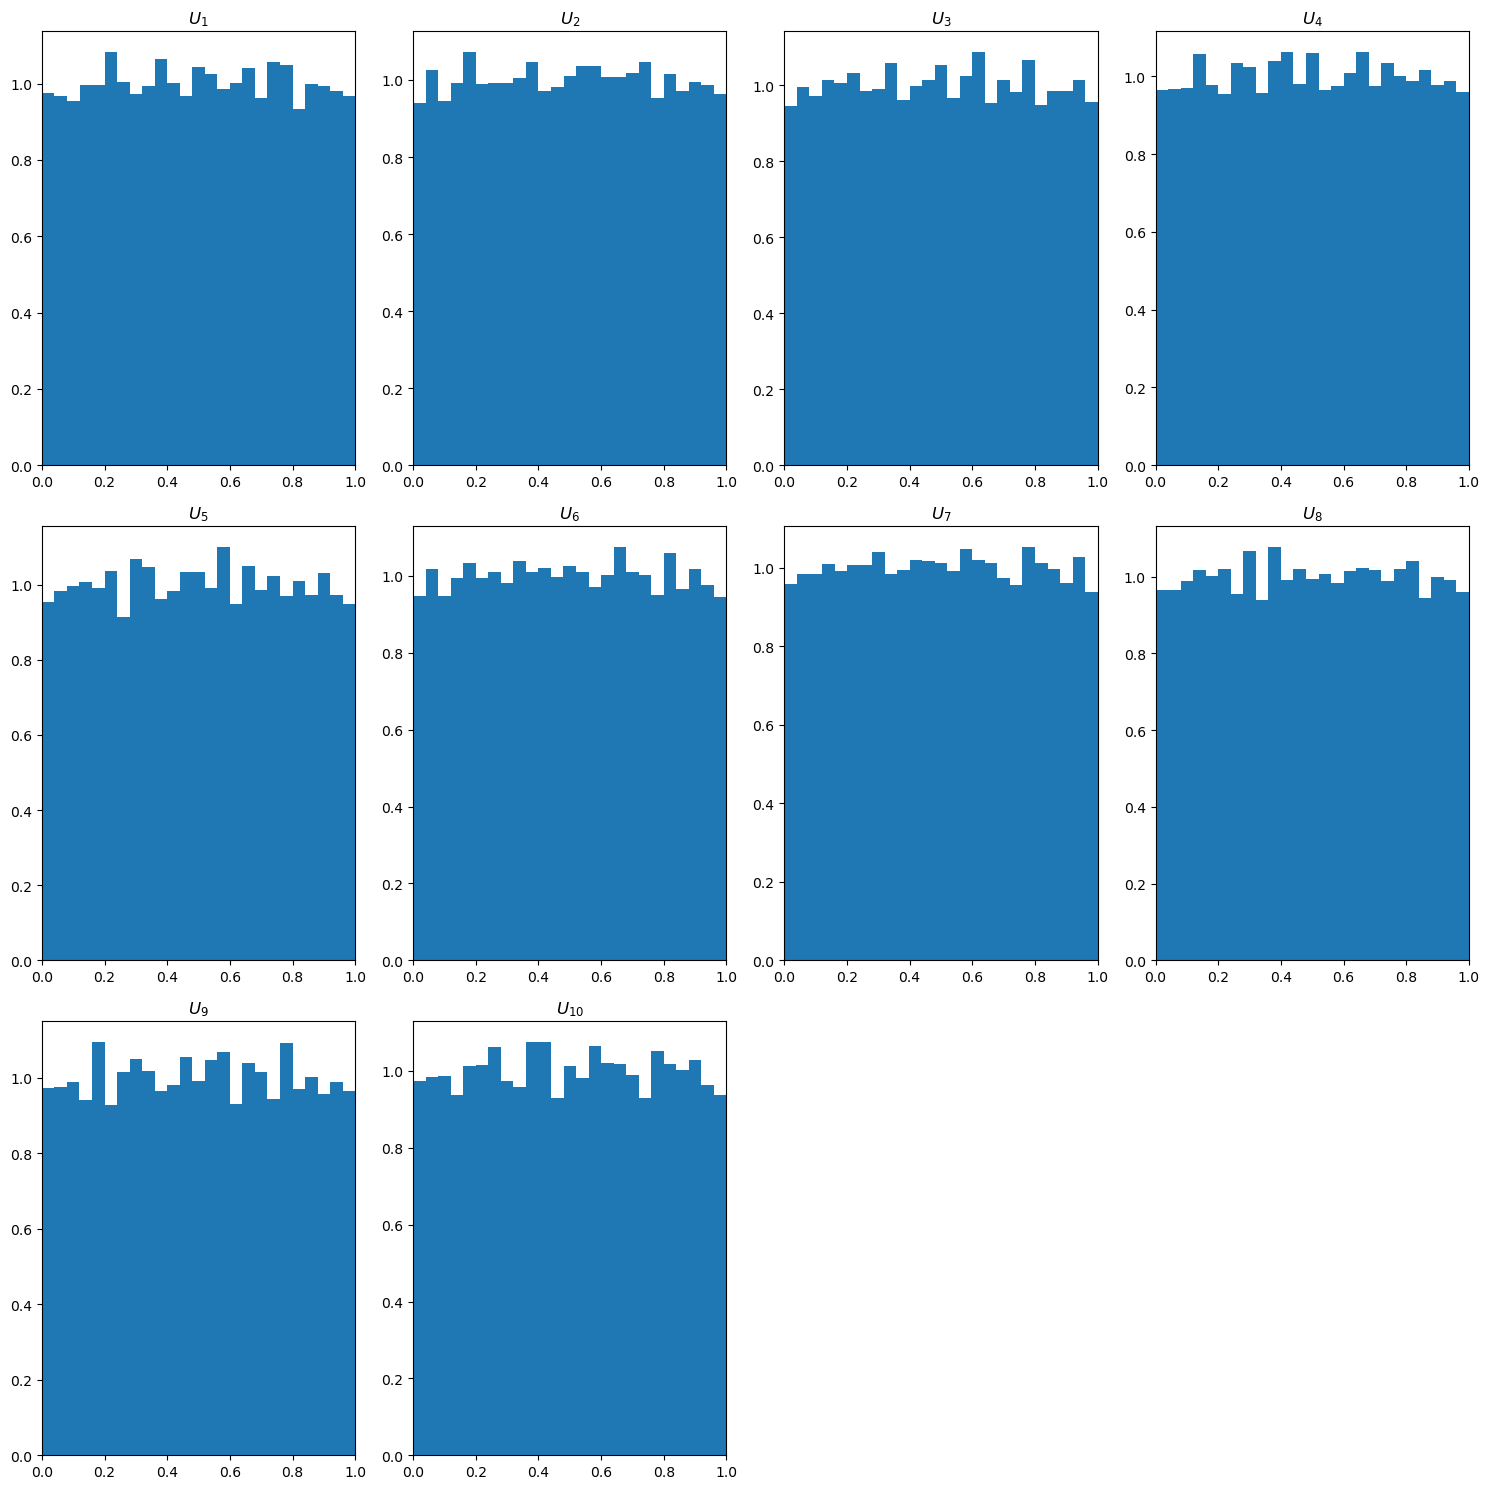

In [ ]:
n_cols = int(np.ceil(np.sqrt(N)))
n_rows = int(np.ceil(N / n_cols))
fig, ax = plt.subplots(n_rows,n_cols, figsize=(15,15))

for i in range(N):
    ax.flat[i].hist(U[i,:], density=True, bins = 25)
    ax.flat[i].set_title("$U_{" +f"{i+1}" + "}$")
    ax.flat[i].set_xlim([0,1])

for i in range(N,n_rows*n_cols):
    ax.flat[i].axis("off")

fig.tight_layout()

In [ ]:
G = np.zeros((N,N))

count = 0


for i in range(N-1):
    # kernel_i = kernels_U[i]
    # h_i = h[i]
    u_i = U[i,:]
    for j in range(i+1, N):
        print(f"{ count } / { (N*(N-1)/2) :3.0f}    [{100*count/ (N*(N-1)/2) :7.2f}%]    ({i}, {j})\033[K", end ="\r")

        u_j = U[j,:]

        kernel_ij = gaussian_kde(np.vstack([u_i,u_j]))

        d_vol = kernel_ij.integrate_box(
                low_bounds = [0,0],
                high_bounds = [1,1]
            )
        
        # Simple normalization of KDE such that integrates to 1 (no jackknifing)
        G[i,j] = G[j,i] = \
            scipy.integrate.dblquad(
                lambda x,y : 
                    kernel_ij.pdf(np.vstack([x,y])) * \
                    kernel_ij.logpdf(np.vstack([x,y])),
                0,1,
                0,1
            )[0] / d_vol - np.log(d_vol)

        count += 1
        print(f"{ count } / { (N*(N-1)/2) :3.0f}    [{100*count/ (N*(N-1)/2) :7.2f}%]    ({i}, {j})\033[K", end ="\r")
        

In [ ]:
G_dir = ND(G, alpha=0.25)

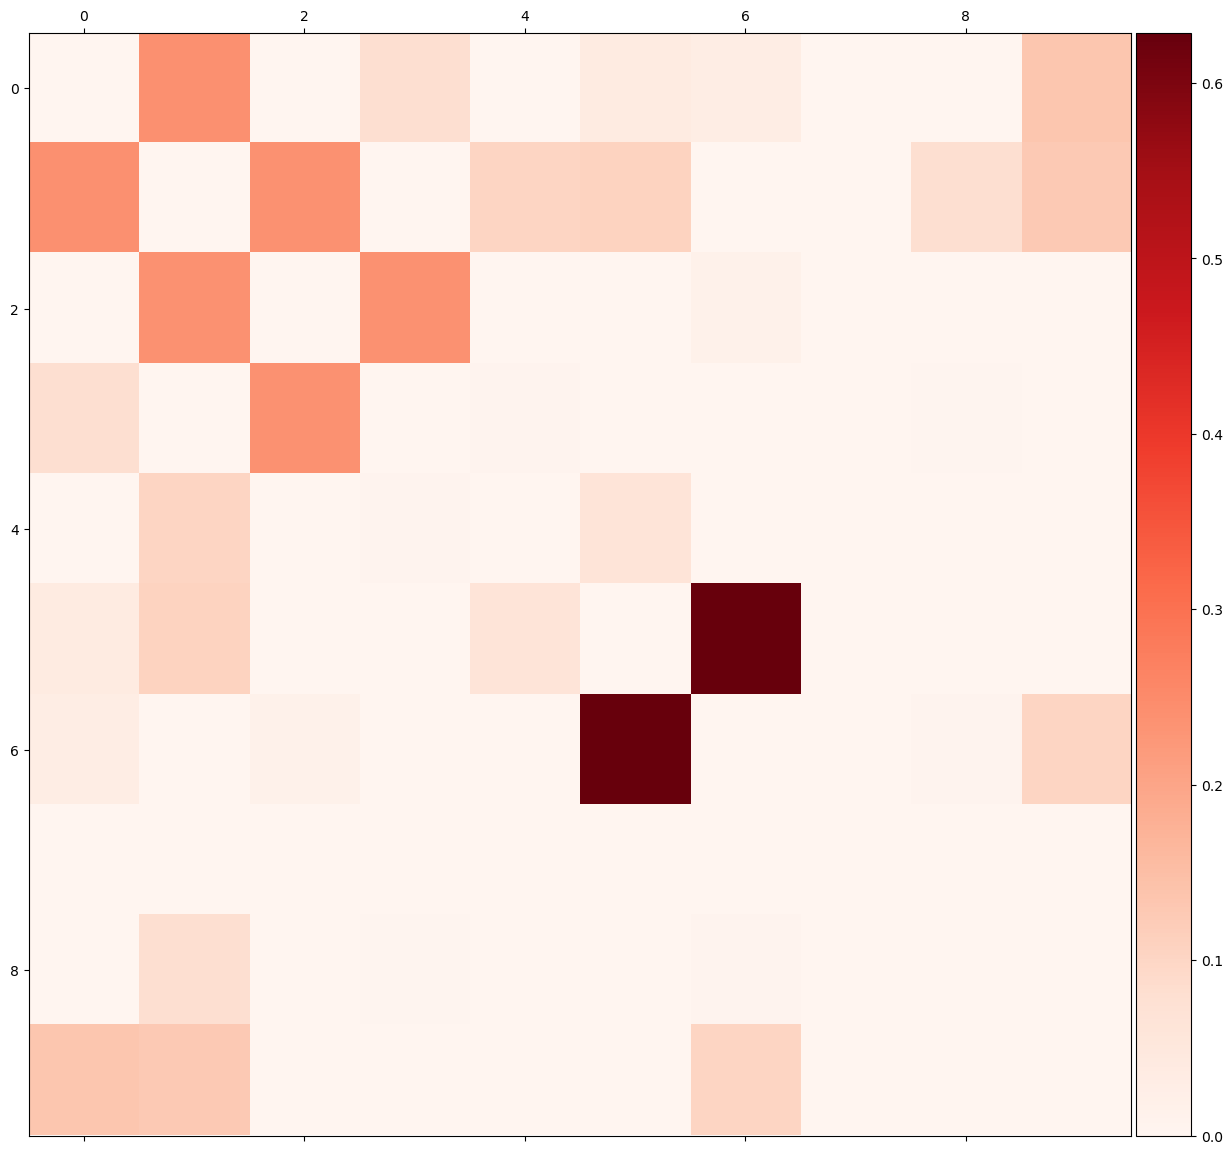

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(15,15))
r = ax.matshow(G_dir, cmap = "Reds", vmin=0)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(r, cax=cax)

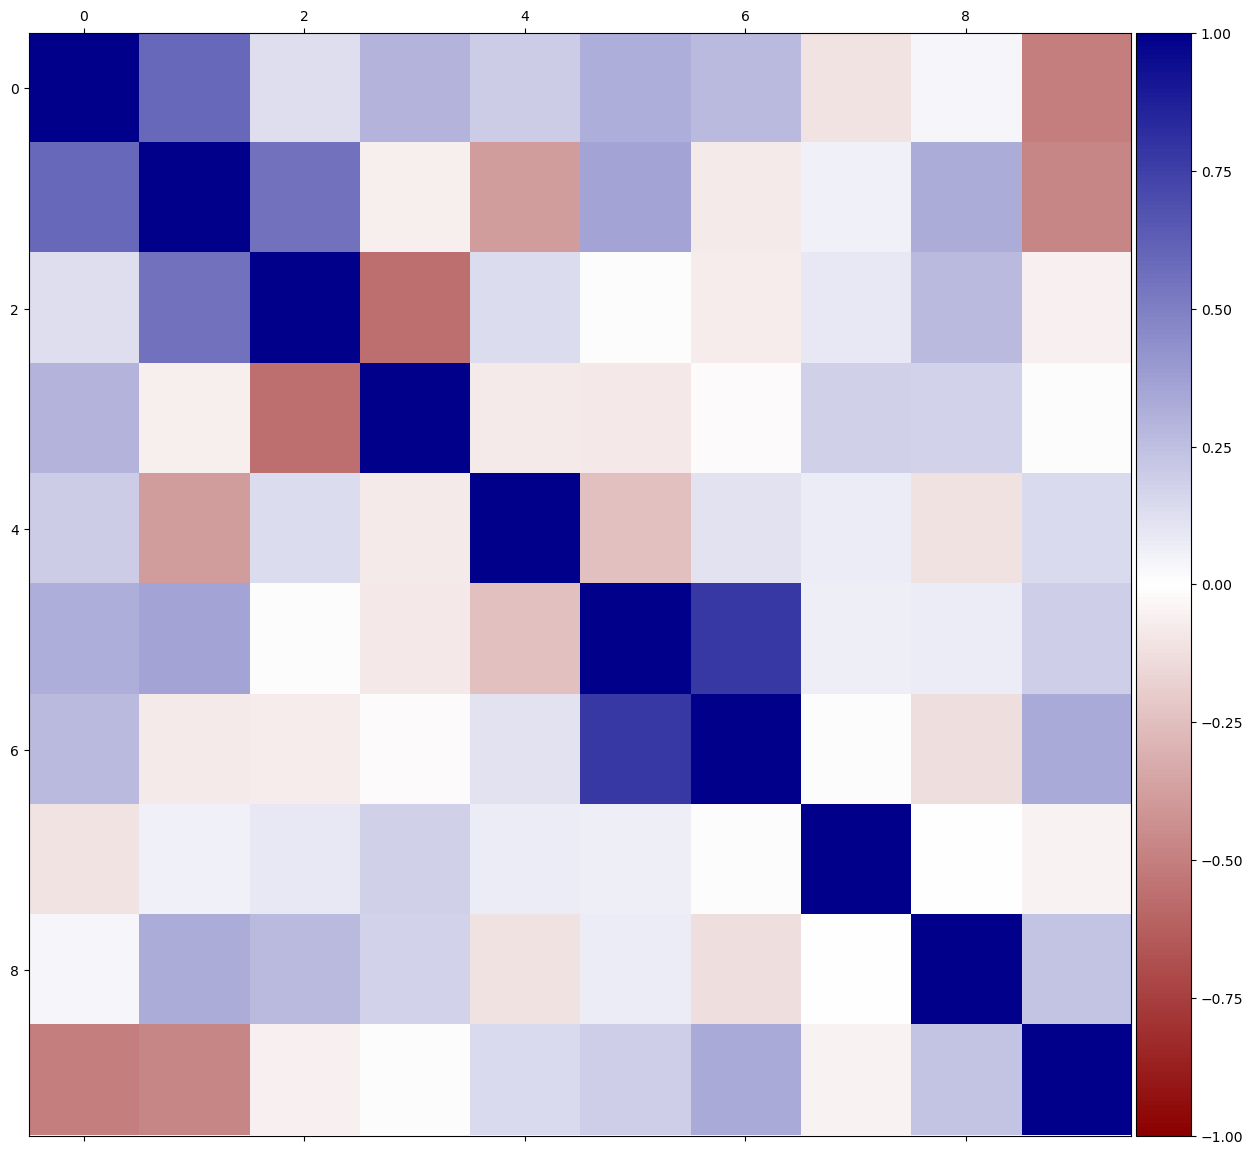

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(15,15))
r = ax.matshow(cor, cmap = colormap_corr, vmin=-1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(r, cax=cax)

In [ ]:
temp = ND(-np.log(1-(cor-np.identity(10))**2)/2)

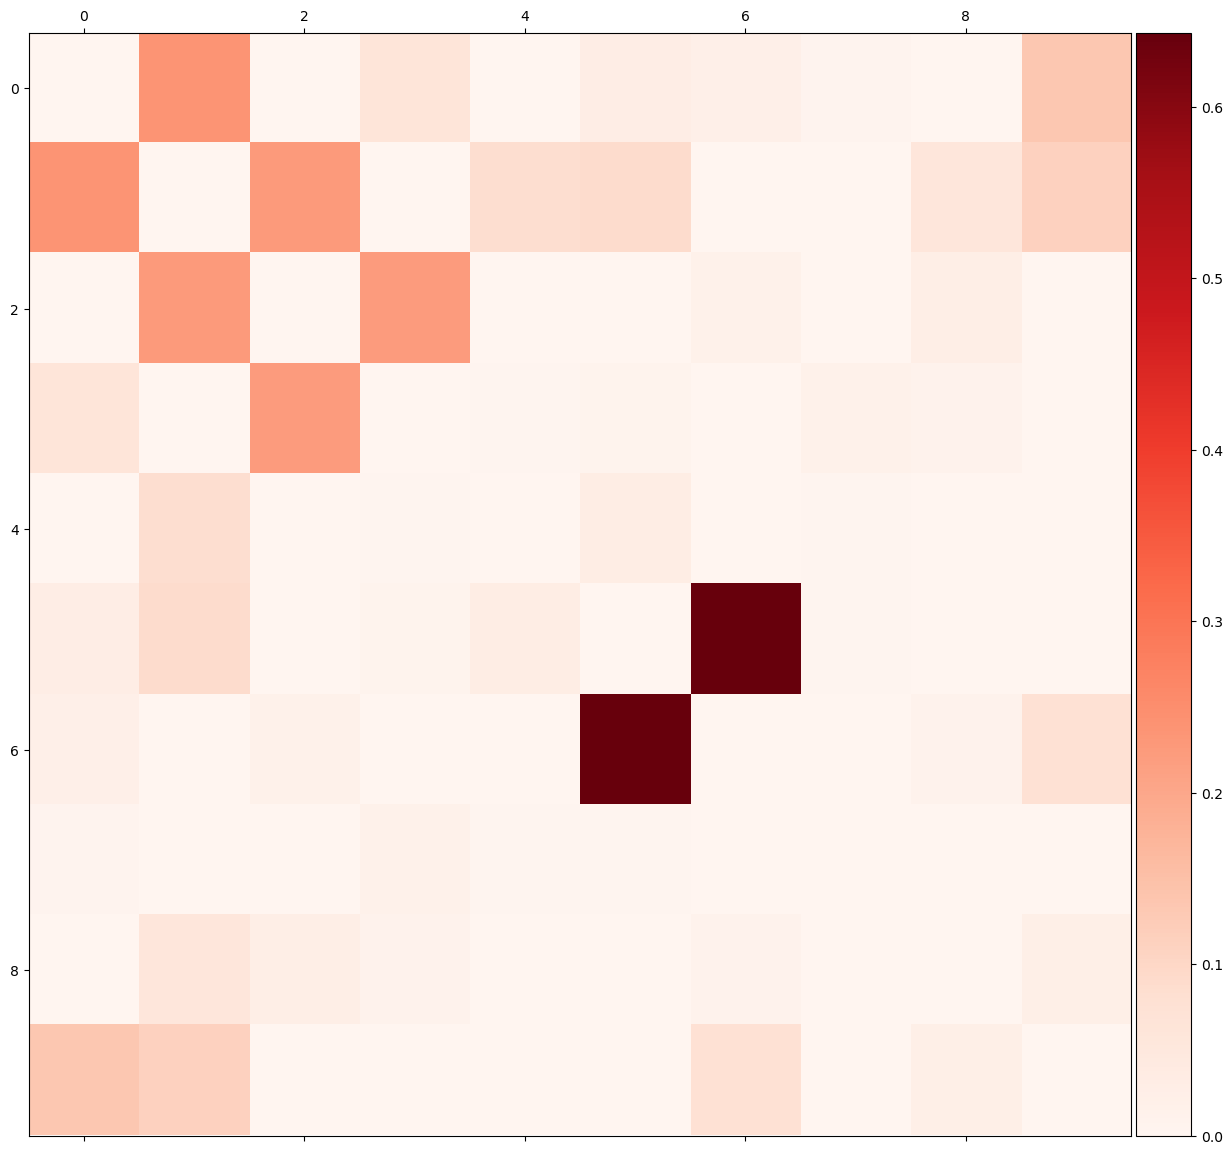

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(15,15))
r = ax.matshow(temp, cmap = "Reds", vmin=0)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(r, cax=cax)

In [ ]:
-np.log(1-(cor-np.identity(10))**2)/2

array([[-0.00000000e+00,  2.15567866e-01,  8.55829027e-03,
         4.45927294e-02,  2.01932306e-02,  5.18470021e-02,
         3.88345012e-02,  5.86400642e-03,  5.17293944e-04,
         1.44998922e-01],
       [ 2.15567866e-01, -0.00000000e+00,  1.82365004e-01,
         2.37990277e-03,  7.99292324e-02,  6.62364576e-02,
         3.20994367e-03,  1.52367405e-03,  5.57991806e-02,
         1.24435372e-01],
       [ 8.55829027e-03,  1.82365004e-01, -0.00000000e+00,
         1.90947669e-01,  9.55602880e-03,  9.77820249e-05,
         2.78150639e-03,  4.03228045e-03,  3.71818112e-02,
         1.58503110e-03],
       [ 4.45927294e-02,  2.37990277e-03,  1.90947669e-01,
        -0.00000000e+00,  3.32150604e-03,  3.82464716e-03,
         1.58512800e-04,  1.66537251e-02,  1.54889677e-02,
         1.17884292e-04],
       [ 2.01932306e-02,  7.99292324e-02,  9.55602880e-03,
         3.32150604e-03, -0.00000000e+00,  3.19076022e-02,
         6.62522527e-03,  2.73418203e-03,  6.16830124e-03,
         1.